**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [48]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [49]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self
    
    def get_best_ranks(self, ranks, top, return_ranks=False):
        indices = np.argpartition(ranks, top, axis=1)[:, :top]
        ranks_top = np.take_along_axis(ranks, indices, axis=1)
        indices = np.take_along_axis(indices, ranks_top.argsort(axis=1), axis=1)
        return indices
    
    def predict(self, X):
        if (self.algorithm == 'brute'):
            if (self.metric == 'euclidean'):
                distances = euclidean_distances(X, self.X_train)
            elif (self.metric == 'cosine'):
                distances = cosine_distances(X, self.X_train)
            pred = self.y_train[self.get_best_ranks(distances, self.n_neighbors)]
            return np.apply_along_axis(lambda r: np.bincount(r).argmax(), 1, pred)
        elif (self.algorithm == 'kd_tree'):
            tree = KDTree(self.X_train)
            dist, labels = tree.query(X, k=self.n_neighbors)
            return np.apply_along_axis(lambda r: np.bincount(r).argmax(), 1, self.y_train[labels])

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [50]:
iris = datasets.load_iris()

In [51]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [52]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [53]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=2)

In [54]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [55]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [56]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=2)

In [57]:
%time clf.predict(X_test)

Wall time: 2.96 ms


array([2, 0, 2, 0, 2, 1, 0, 1, 0, 2, 2, 0, 1, 2, 1])

In [58]:
%time my_clf.predict(X_test)

Wall time: 2 ms


array([2, 0, 2, 0, 2, 1, 0, 1, 0, 2, 2, 0, 1, 2, 1], dtype=int64)

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [59]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [60]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [61]:
%time clf.fit(X_train, y_train)

Wall time: 957 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [70]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


MyKNeighborsClassifier(algorithm='kd_tree', metric='euclidean', n_neighbors=2)

In [74]:
%time clf.predict(X_test)

Wall time: 2.96 ms


array([2, 0, 2, 0, 1, 0, 1, 1, 2, 2, 2, 0, 1, 0, 1])

In [72]:
%time my_clf.predict(X_test)

Wall time: 957 µs


array([2, 0, 2, 0, 1, 0, 1, 1, 2, 2, 2, 0, 1, 0, 1], dtype=int64)

In [75]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [76]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [77]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [78]:
vectorizer = CountVectorizer()

In [79]:
data = vectorizer.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [80]:
def get_cv_score(data, target, clf_metric='euclidean'):
    cv = KFold(n_splits=3)
    final_scores = []
    for n_neighbors in range(1, 11):
        scores = []
        for train_index, test_index in cv.split(target):
            clf = MyKNeighborsClassifier(n_neighbors, metric=clf_metric)
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = target[train_index], target[test_index]
            clf.fit(X_train, y_train)
            scores.append(accuracy_score(clf.predict(X_test), y_test))
        score = np.asarray(scores).mean()
        final_scores.append(score)
    return final_scores

In [24]:
scores = [get_cv_score(data, target, 'euclidean'), get_cv_score(data, target, 'cosine')]

In [25]:
scores[0]

[0.20647001980379184,
 0.18357766789940044,
 0.1833128611975131,
 0.18163377579955453,
 0.1853459908124729,
 0.1834018409361915,
 0.18428561572807456,
 0.1875558847594979,
 0.1914449812755884,
 0.1915330236454106]

In [26]:
scores[1]

[0.29238085971534544,
 0.27258184847076233,
 0.26904644465835204,
 0.2657761053242645,
 0.2623294937767613,
 0.25782189785510323,
 0.2577333868008529,
 0.2552586861519406,
 0.25260710399985603,
 0.24748091493574478]

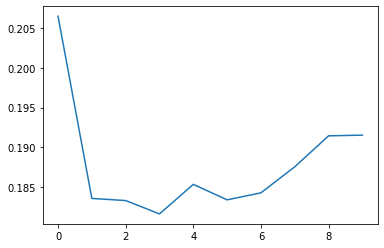

In [27]:
plt.plot(scores[0])

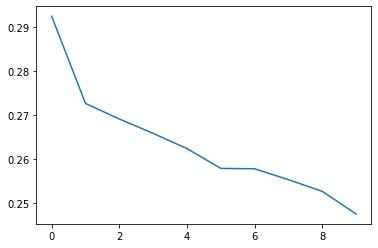

In [28]:
plt.plot(scores[1])

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [29]:
vectorizer_tfidf = TfidfVectorizer()

In [30]:
data = newsgroups['data']
data_tfidf =vectorizer_tfidf.fit_transform(data)

In [31]:
scores_tfidf = [get_cv_score(data_tfidf, target, 'euclidean'), get_cv_score(data_tfidf, target, 'cosine')]

In [32]:
scores_tfidf[0]

[0.1487536649950568,
 0.09174530488343864,
 0.10526774113509181,
 0.09978753128820071,
 0.09589866911432422,
 0.0910375913969786,
 0.08935843569635586,
 0.08750253909788934,
 0.08644176563172708,
 0.08767878787708357]

In [33]:
scores_tfidf[1]

[0.5958995830489591,
 0.5569195444124895,
 0.5657585343450543,
 0.5711500222297023,
 0.5710620032941017,
 0.5684986041171677,
 0.5687639732403689,
 0.566907936036574,
 0.5673497648469619,
 0.5675268806923482]

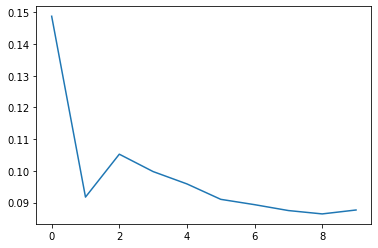

In [34]:
plt.plot(scores_tfidf[0])

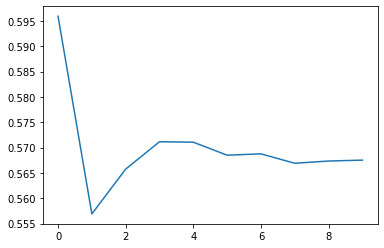

In [35]:
plt.plot(scores_tfidf[1])

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [36]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [37]:
data_test = newsgroups['data']
target_test = newsgroups['target']

In [38]:
data_test = vectorizer_tfidf.transform(data_test)

In [176]:
my_clf = MyKNeighborsClassifier(n_neighbors=12, algorithm='brute', metric='cosine')

In [177]:
my_clf.fit(data_tfidf, target)

MyKNeighborsClassifier(algorithm='brute', metric='cosine', n_neighbors=12)

In [178]:
my_pred = my_clf.predict(data_test)

In [180]:
accuracy_score(my_pred, target_test)

0.5139405204460966

Тестовая часть может быть недостаточно репрезентативной